# Dementia Prediction

Using MRI data from patients w/ and w/o Alzheimier's, develop model that can predict if a patient is demented

Based on: https://www.kaggle.com/ruslankl/dementia-prediction-w-tree-based-models

In [1]:
##########################################
# Setup project path to use dex.py module
##########################################

import os
import sys

# Set project path
parent_project_name = 'Python_Notebooks_For_Machine_Learning'
path = os.getcwd()
parent_project_name = path[0: path.index(parent_project_name) + len(parent_project_name)]

# Import dex.py library
sys.path.insert(0, parent_project_name + os.sep + 'common')
import dex

## Data Preparation

In [12]:
import pandas as pd
import numpy as np
from functools import reduce
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

# Import data to dataframe
data_dir = os.path.join(parent_project_name,'Projects', 'DementiaPrediction','data')
cs_df = pd.read_csv(os.path.join(data_dir,'oasis_cross-sectional.csv'), index_col='ID')
long_df = pd.read_csv(os.path.join(data_dir,'oasis_longitudinal.csv'), index_col=['Subject ID', 'MRI ID'])
dex.set_columns_to_category_dtype(cs_df)
dex.set_columns_to_category_dtype(long_df)

# Used for plotting
group_enum = dex.enumerate_column(long_df['Group'])

# Normalized data
long_df

In [4]:
cs_df.head()

,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
ID,,,,,,,,,,,
OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN
OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN
OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN
OAS1_0004_MR1,M,R,28,NaN,NaN,NaN,NaN,1588,0.803,1.105,NaN
OAS1_0005_MR1,M,R,18,NaN,NaN,NaN,NaN,1737,0.848,1.010,NaN


In [5]:
long_df.head()

Group  Visit  MR Delay M/F Hand  Age  EDUC  \
Subject ID MRI ID                                                            
OAS2_0001  OAS2_0001_MR1  Nondemented      1         0   M    R   87    14   
           OAS2_0001_MR2  Nondemented      2       457   M    R   88    14   
OAS2_0002  OAS2_0002_MR1     Demented      1         0   M    R   75    12   
           OAS2_0002_MR2     Demented      2       560   M    R   76    12   
           OAS2_0002_MR3     Demented      3      1895   M    R   80    12   

                          SES  MMSE  CDR  eTIV   nWBV    ASF Group_enum  
Subject ID MRI ID                                                        
OAS2_0001  OAS2_0001_MR1  2.0  27.0  0.0  1987  0.696  0.883          0  
           OAS2_0001_MR2  2.0  30.0  0.0  2004  0.681  0.876          0  
OAS2_0002  OAS2_0002_MR1  NaN  23.0  0.5  1678  0.736  1.046          1  
           OAS2_0002_MR2  NaN  28.0  0.5  1738  0.713  1.010          1  
           OAS2_0002_MR3  NaN  22.0  0.5  1698  0.701  1.034          1

In [9]:
cs_df.describe()

,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
count,436.000000,235.000000,216.000000,235.00000,235.000000,436.000000,436.000000,436.000000,20.00000
mean,51.357798,3.178723,2.490741,27.06383,0.285106,1481.919725,0.791670,1.198894,20.55000
std,25.269862,1.311510,1.120593,3.69687,0.383405,158.740866,0.059937,0.128682,23.86249
min,18.000000,1.000000,1.000000,14.00000,0.000000,1123.000000,0.644000,0.881000,1.00000
25%,23.000000,2.000000,2.000000,26.00000,0.000000,1367.750000,0.742750,1.111750,2.75000
50%,54.000000,3.000000,2.000000,29.00000,0.000000,1475.500000,0.809000,1.190000,11.00000
75%,74.000000,4.000000,3.000000,30.00000,0.500000,1579.250000,0.842000,1.284250,30.75000
max,96.000000,5.000000,5.000000,30.00000,2.000000,1992.000000,0.893000,1.563000,89.00000


In [10]:
long_df.describe()

,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,373.000000,373.000000,373.000000,373.000000,354.000000,371.000000,373.000000,373.000000,373.000000,373.000000
mean,1.882038,595.104558,77.013405,14.597855,2.460452,27.342318,0.290885,1488.128686,0.729568,1.195461
std,0.922843,635.485118,7.640957,2.876339,1.134005,3.683244,0.374557,176.139286,0.037135,0.138092
min,1.000000,0.000000,60.000000,6.000000,1.000000,4.000000,0.000000,1106.000000,0.644000,0.876000
25%,1.000000,0.000000,71.000000,12.000000,2.000000,27.000000,0.000000,1357.000000,0.700000,1.099000
50%,2.000000,552.000000,77.000000,15.000000,2.000000,29.000000,0.000000,1470.000000,0.729000,1.194000
75%,2.000000,873.000000,82.000000,16.000000,3.000000,30.000000,0.500000,1597.000000,0.756000,1.293000
max,5.000000,2639.000000,98.000000,23.000000,5.000000,30.000000,2.000000,2004.000000,0.837000,1.587000


## Data Exploration

#### Create Data Quality Reports

Notes:
1. Drop columns where cardinality = 1
2. Consider removing columns where null pct >= 30%


In [8]:
# Get data quality reports
cs_continuous, cs_categorical, cs_error = dex.get_data_quality_report(cs_df)
cs_continuous

,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
count,436,436,436,436,436,436,436,436,436
nulls,0,201,220,201,201,0,0,0,416
nulls pct,0.00,0.46,0.50,0.46,0.46,0.00,0.00,0.00,0.95
std,25.2699,1.31151,1.12059,3.69687,0.383405,158.741,0.059937,0.128682,23.8625
min,18,1,1,14,0,1123,0.644,0.881,1
25%,23,2,2,26,0,1367.75,0.74275,1.11175,2.75
50%,54,3,2,29,0,1475.5,0.809,1.19,11
mean,51.3578,3.17872,2.49074,27.0638,0.285106,1481.92,0.79167,1.19889,20.55
75%,74,4,3,30,0.5,1579.25,0.842,1.28425,30.75
max,96,5,5,30,2,1992,0.893,1.563,89


In [4]:
# Get data quality reports
long_continuous, long_categorical, long_error = dex.get_data_quality_report(long_df)
long_continuous

,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,373,373,373,373,373,373,373,373,373,373
nulls,0,0,0,0,19,2,0,0,0,0
nulls pct,0.00,0.00,0.00,0.00,0.05,0.01,0.00,0.00,0.00,0.00
std,0.922843,635.485,7.64096,2.87634,1.134,3.68324,0.374557,176.139,0.037135,0.138092
min,1,0,60,6,1,4,0,1106,0.644,0.876
25%,1,0,71,12,2,27,0,1357,0.7,1.099
50%,2,552,77,15,2,29,0,1470,0.729,1.194
mean,1.88204,595.105,77.0134,14.5979,2.46045,27.3423,0.290885,1488.13,0.729568,1.19546
75%,2,873,82,16,3,30,0.5,1597,0.756,1.293
max,5,2639,98,23,5,30,2,2004,0.837,1.587


### Plot data

##### 1a. Longitudinal data, continuous

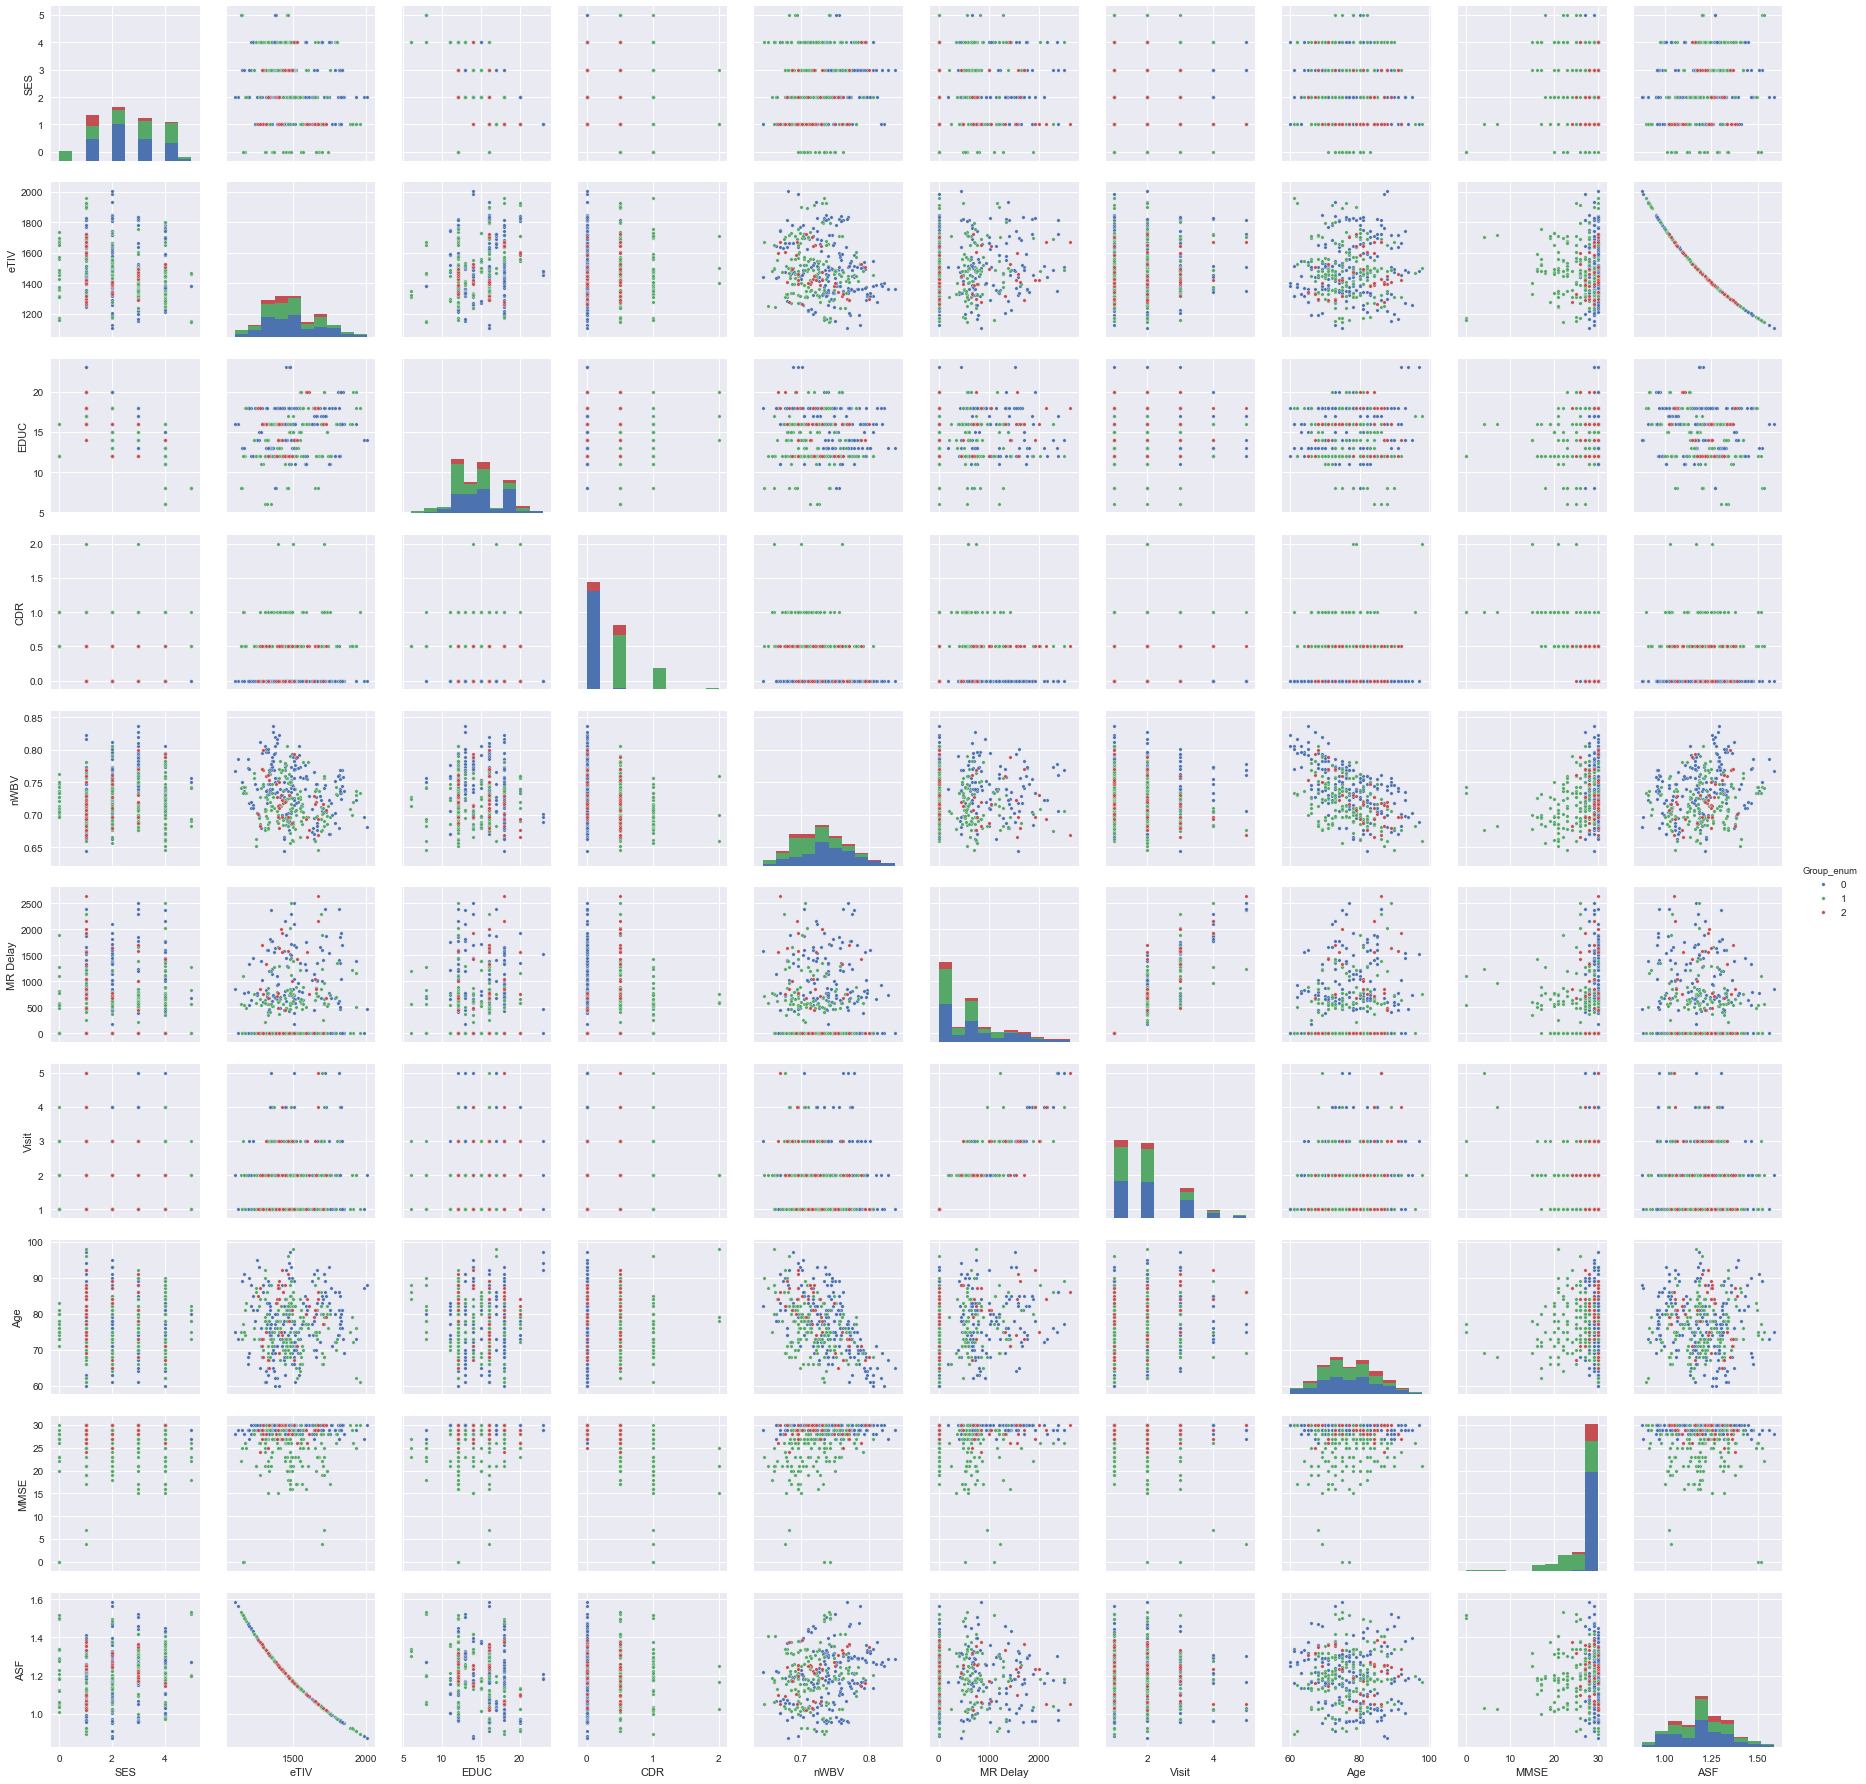

In [6]:
# Get continous variables in longitudinal data df
label = 'Group_enum'
plot_df = dex.get_continuous_data(long_df)
plot_vars = set(plot_df.columns) - set([label])
sns.pairplot(data=plot_df,
             hue=label,
             vars=plot_vars,
             diag_kind='hist',
             kind='scatter',
             markers='.')
plt.show()

##### 1b. Longitudinal data, categorical

KeyError: 'Group_enum'

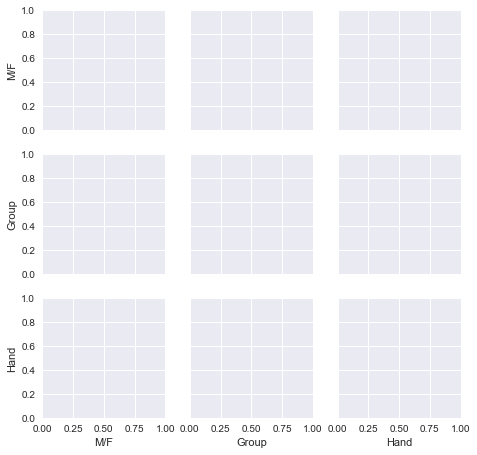

In [11]:
# Get categorical variables in longitudinal data df
# label = 'Group_enum'
# plot_df = dex.get_categorical_data(long_df, False)
# plot_vars = set(plot_df.columns) - set([label])
# sns.facetplot(data=plot_df,
#              hue=label,
#              vars=plot_vars,
#              diag_kind='hist',
#              kind='scatter')
# plt.show()

##### 1c. Longitudinal data, continuous, PCA

In [31]:
from sklearn.decomposition import PCA

PCA.transform()

##### 2a. Cross-Sectional data, continuous

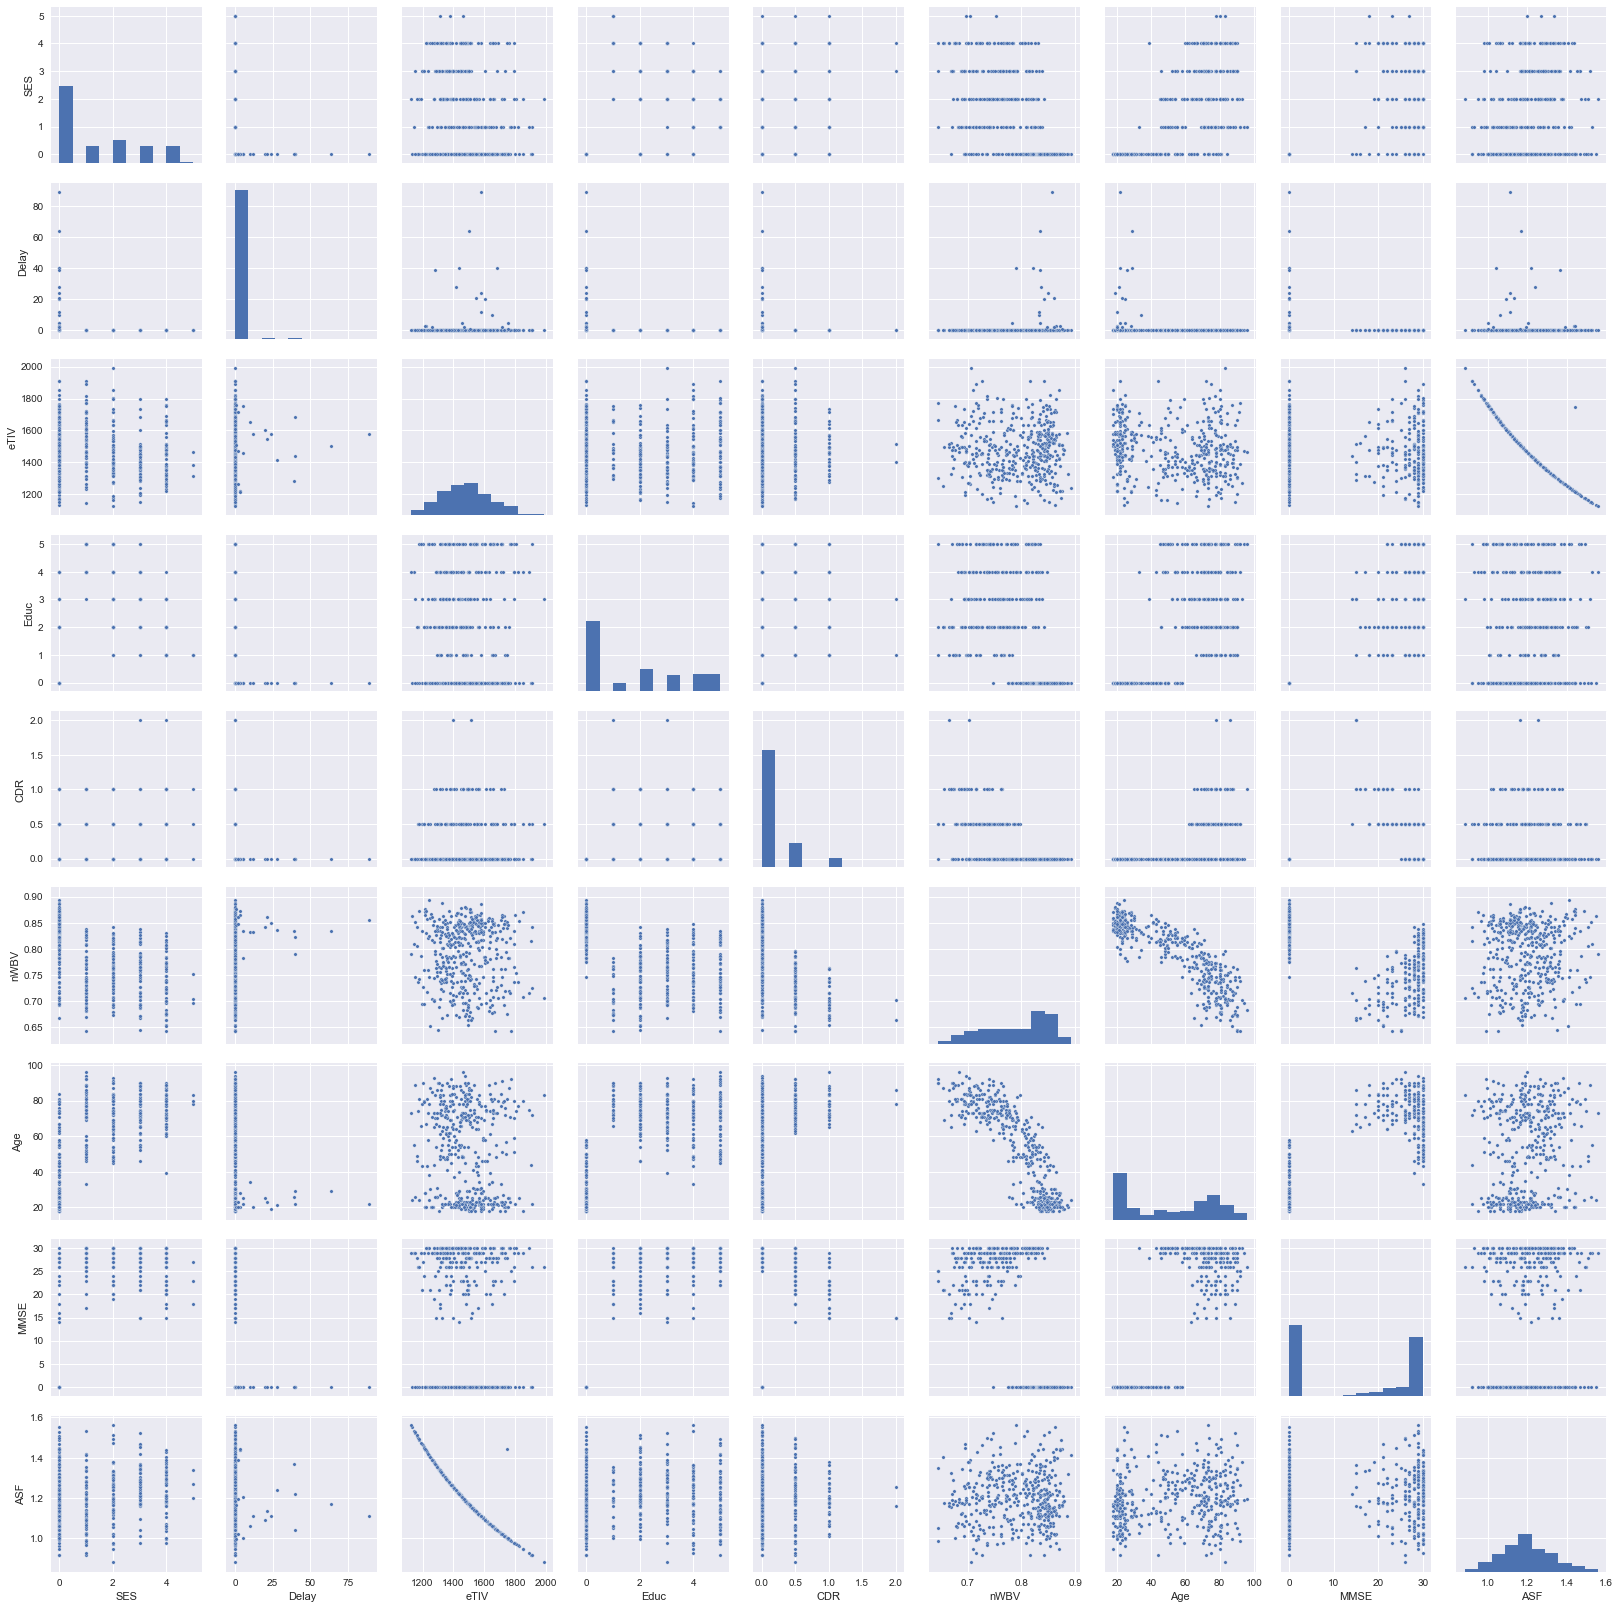

In [13]:
# Get continous variables in cross-sectional data df
plot_df = dex.get_continuous_data(cs_df)
plot_vars = set(plot_df.columns)
sns.pairplot(data=plot_df,
             vars=plot_vars,
             diag_kind='hist',
             kind='scatter',
             markers='.')
plt.show()

##### 2b. Cross-Sectional data, categorical

Plotting categorical data
    Enumerate categorical features, create dataframe, then pairplot
    FacetGrid of histograms- each categorical feature in a row, cols set by cardinality of target feature 

### Predictive modeling 

##### 1. Train and evaluate Decision Tree

##### 2. Train and evaluate Naive Bayes

##### 3. Train and evaluate SVM

In [26]:
df_norm = pd.DataFrame(plot_df.apply(lambda x: (x-x.mean()) / (x.max()-x.min())))

In [27]:
pd.concat([plot_df,df_norm],axis=1)

,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
ID,,,,,,,,,,,,,,,,,,
OAS1_0001_MR1,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,0.0,0.290285,0.057339,0.353211,0.480428,-0.076835,-0.158711,-0.195461,0.157046,-0.010592
OAS1_0002_MR1,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,0.0,0.046695,0.457339,-0.046789,0.480428,-0.076835,-0.385408,0.073616,0.486958,-0.010592
OAS1_0003_MR1,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,0.0,0.277464,0.457339,0.353211,0.413761,0.173165,-0.032129,-0.336023,0.011885,-0.010592
OAS1_0004_MR1,28,0.0,0.0,0.0,0.0,1588,0.803,1.105,0.0,-0.299459,-0.342661,-0.246789,-0.486239,-0.076835,0.122072,0.045503,-0.137675,-0.010592
OAS1_0005_MR1,18,0.0,0.0,0.0,0.0,1737,0.848,1.010,0.0,-0.427664,-0.342661,-0.246789,-0.486239,-0.076835,0.293533,0.226226,-0.276971,-0.010592
OAS1_0006_MR1,24,0.0,0.0,0.0,0.0,1131,0.862,1.551,0.0,-0.350741,-0.342661,-0.246789,-0.486239,-0.076835,-0.403820,0.282451,0.516284,-0.010592
OAS1_0007_MR1,21,0.0,0.0,0.0,0.0,1516,0.830,1.157,0.0,-0.389203,-0.342661,-0.246789,-0.486239,-0.076835,0.039218,0.153937,-0.061429,-0.010592
OAS1_0009_MR1,20,0.0,0.0,0.0,0.0,1505,0.843,1.166,0.0,-0.402023,-0.342661,-0.246789,-0.486239,-0.076835,0.026560,0.206146,-0.048232,-0.010592
OAS1_0010_MR1,74,5.0,2.0,30.0,0.0,1636,0.689,1.073,0.0,0.290285,0.657339,0.153211,0.513761,-0.076835,0.177308,-0.412328,-0.184596,-0.010592
